In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import recall_score, f1_score

from tabulate import tabulate
from pandas.tseries.offsets import MonthEnd
from datetime import timedelta
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
pd.reset_option('display.max_rows')

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
def estimator(df, f):
    model = smf.logit(f, data=df).fit(maxiter=200)
    return(model)

def predictor(new_df, model):
    return model.predict(new_df)

def set_target_label(df):
    data = df.copy()
    data['def_date'] = pd.to_datetime(data['def_date'], errors='coerce')
    data['def_present'] = pd.notna(data['def_date']).astype(int)

    # Convert dates into datetime format for easier use
    data['stmt_date'] = pd.to_datetime(data['stmt_date'])
    data.loc[data['def_present'] == 1, 'def_date'] = pd.to_datetime(data['def_date'])  # Error handles 12/31/99

    # Since financial statements are only available in May of next year, set a new variable
    data['usable_date'] = pd.to_datetime((data['fs_year'] + 1).astype(str) + '-05-01')
    data['default_label'] = 0

    # Define the prediction year range based on 'usable_date'. This will train the model to see if the current data
    # will predict default over the next 12 months.
    data['pred_year_start'] = data['usable_date']
    data['pred_year_end'] = data['usable_date'] + pd.DateOffset(years=1)

    # Assigning default label if it falls within the above window
    data.loc[(data['def_present'] == 1) & \
           (data['def_date'] >= data['pred_year_start']) & \
           (data['def_date'] <= data['pred_year_end']), 'default_label'] = 1
    
    return data

def impute_pre_feat_eng(df):
    ############################################
    # Using other variables to replace missing #
    ############################################
    
    # we can try to estimate it from inc_financing and prof_financing
    df['exp_financing'].fillna(df['inc_financing'] - df['prof_financing'], inplace=True)

    # profit as a proxy assuming that operations are the main profit driver
    df['cf_operations'].fillna(df['profit'], inplace=True)
    df['eqty_tot'].fillna(df['asst_tot'] - (df['liab_lt'] + df['debt_bank_st'] + df['debt_bank_lt'] + df['debt_fin_st'] + df['debt_fin_lt'] + df['AP_st'] + df['AP_lt']), inplace=True)
    df['cf_operations'].fillna(df['cash_and_equiv'], inplace=True)
    df['AP_st'].fillna(df['debt_st'], inplace=True)
    
    # Asset current is missing a lot
    df['asst_current'].fillna(df['AR'] + df['cash_and_equiv'] + df['cf_operations'], inplace=True)
    df['asst_current'].fillna(df['asst_tot'] - (df['asst_fixed_fin'] + df['asst_tang_fixed'] + df['asst_intang_fixed']),
                              inplace=True)

    df['days_rec'].fillna((df['AR'] / df['rev_operating']) * 365, inplace=True) 
    df['roe'].fillna(df['profit'] / df['eqty_tot'], inplace=True)
    df['roa'].fillna(df['profit'] / df['asst_tot'], inplace=True)
    
    return df

def impute_post_feat_eng(df):
    ########################################################
    # Replace missing values in feature engineered columns #
    ########################################################
    
    df['rev_operating'].fillna(df['profit'] / df['net_profit_margin'], inplace=True)
    df['gross_profit'].fillna(df['prof_operations'] - df['taxes'] + df['cf_operations'], inplace=True)
    df['debt_coverage'].fillna(df['cf_operations'] / df['exp_financing'], inplace=True)
    df['debt_ratio'].fillna(df['asst_tot'] - df['eqty_tot'], inplace=True)
    
    return df

def feature_engineering(df):
    #############
    # Liquidity #
    #############
    df['time_interest_earned'] = df['ebitda'] / (df['exp_financing'] + 1) # exp_financing covers interest expenses
    # subtract other assets from the total current assets to estimate inventory
    df['inventory'] = df['asst_current'] - (df['asst_intang_fixed'] + df['asst_tang_fixed'] + df['asst_fixed_fin']) 
    df['current_ratio'] = df['asst_current'] / (df['debt_st'] + df['AP_st'] + 1) # current liabilities 
    df['quick_ratio'] = (df['asst_current'] - df['inventory']) / (df['debt_st'] + df['AP_st'] + 1)
    df['cash_ratio'] = (df['cash_and_equiv'] + df['cf_operations']) / (df['debt_st'] + df['AP_st'] + 1)        

    ########
    # Size #
    ########
    # df['asst_tot']

    #################
    # Debt Coverage #
    #################
    df['debt_coverage'] = df['ebitda'] / (df['inc_financing'] - df['exp_financing'] + 1)

    df['debt_ratio'] = (df['liab_lt'] + df['debt_bank_st'] + df['debt_bank_lt'] + df['debt_fin_st'] \
                     + df['debt_fin_lt'] + df['AP_st'] + df['AP_lt'])/ df['asst_tot']

    df['leverage_ratio'] = df['asst_tot'] / (df['eqty_tot'] + 1)

    #################
    # Profitability #
    #################
    df['gross_profit'] = df['rev_operating'] - df['COGS'] + df['prof_operations'] - df['taxes'] + df['cf_operations']
    df['net_profit_margin'] = df['profit'] / (df['rev_operating'] + 1) # aka profit margin ratio
    # df['roe']
    # df['roa']
    df['gross_profit_margin'] = (df['rev_operating'] - df['COGS']) / (df['rev_operating'] + 1)
    df['earning_power'] = df['ebitda'] / df['asst_tot']
    df['cash_return_assets'] = df['cf_operations'] / df['asst_tot']

    ############
    # Activity #
    ############
    # dd['days_rec']
    df['asset_turnover'] = df['rev_operating'] / df['asst_tot']
    df['nwc'] = df['asst_current'] / (df['asst_current'] - (df['debt_st'] + df['AP_st'] + df['debt_fin_lt']))

    ############
    # Leverage #
    ############
    df['leverage'] = (df['debt_lt'] + df['debt_st']) / df['asst_tot']
    
    return df

def impute_median_train(df):

    preproc_params = {}
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for column in df.columns:
        # Check if column is numeric
        if df[column].dtype == 'float64':
            median = df[column].median()
            preproc_params[column + '_median'] = median
            df[column].fillna(median, inplace=True)
        
    return df, preproc_params

def impute_median_test(df, preproc_params={}):
    ###########################
    # Replace nan with median #
    ###########################
    
    # Before imputing, replace inf and -inf with nan. Very small observations in the variables have
    # zero as denominator, in which case we replace these observations with nan and replace with median.
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    for column in df.columns:
        median_key = column + '_median'
        if median_key in preproc_params:
            df[column].fillna(preproc_params[median_key], inplace=True)

    return df

def check_missing_values(df):

    missing_values = df.isnull().sum()
    missing_percentage = round((missing_values / len(df)) * 100, 2)
    missing_data = pd.DataFrame({'Missing Values (Count)': missing_values, 'Percentage (%)': missing_percentage})
    missing_data = missing_data.sort_values(by='Missing Values (Count)', ascending=False)

    return missing_data

In [3]:
def feature_engineering(df):
    ##########################
    # ------ Liquidity ----- #
    ##########################
    df['time_interest_earned'] = df['ebitda'] / (df['exp_financing'] + 1) # exp_financing covers interest expenses
    # subtract other assets from the total current assets to estimate inventory
    df['inventory'] = df['asst_current'] - (df['asst_intang_fixed'] + df['asst_tang_fixed'] + df['asst_fixed_fin']) 
    df['current_ratio'] = df['asst_current'] / (df['debt_st'] + df['AP_st'] + 1) # current liabilities 
    df['quick_ratio'] = (df['asst_current'] - df['inventory']) / (df['debt_st'] + df['AP_st'] + 1)
    df['cash_ratio'] = (df['cash_and_equiv'] + df['cf_operations']) / (df['debt_st'] + df['AP_st'] + 1)        

    #########################
    # -------- Size ------- #
    #########################
    # df['asst_tot']

    ##############################
    # ------ Debt Coverage ----- #
    ##############################
    df['debt_coverage'] = df['ebitda'] / (df['inc_financing'] - df['exp_financing'] + 1)

    df['debt_ratio'] = (df['liab_lt'] + df['debt_bank_st'] + df['debt_bank_lt'] + df['debt_fin_st'] \
                     + df['debt_fin_lt'] + df['AP_st'] + df['AP_lt'])/ df['asst_tot']

    df['leverage_ratio'] = df['asst_tot'] / (df['eqty_tot'] + 1)

    ##############################
    # ------ Profitability ----- #
    ##############################
    df['gross_profit'] = df['rev_operating'] - df['COGS'] + df['prof_operations'] - df['taxes'] + df['cf_operations']
    df['net_profit_margin'] = df['profit'] / (df['rev_operating'] + 1) # aka profit margin ratio
    # df['roe']
    # df['roa']
    df['gross_profit_margin'] = (df['rev_operating'] - df['COGS']) / (df['rev_operating'] + 1)
    df['earning_power'] = df['ebitda'] / df['asst_tot']
    df['cash_return_assets'] = df['cf_operations'] / df['asst_tot']

    #########################
    # ------ Activity ----- #
    #########################
    # dd['days_rec']
    df['asset_turnover'] = df['rev_operating'] / df['asst_tot']
    df['nwc'] = df['asst_current'] / (df['asst_current'] - (df['debt_st'] + df['AP_st'] + df['debt_fin_lt']))

    #########################
    # ------ Leverage ----- #
    #########################
    df['leverage'] = (df['debt_lt'] + df['debt_st']) / df['asst_tot']
    
    return df

## Total Feature Engineered Variables

In [4]:
features = [
    # Liquidity
    'current_ratio',
    'time_interest_earned',
    'quick_ratio',
    'cash_ratio',
    # Size
    'asst_tot',
    # Debt Coverage
    'debt_coverage',
    'debt_ratio',
    'leverage_ratio',
    # Profitability
    'gross_profit',
    'net_profit_margin',
    'roe',
    'roa',
    'gross_profit_margin',
    'earning_power',
    'cash_return_assets',
    # Activity
    'days_rec',
    'nwc',
    'asset_turnover',
    # Leverage
    'leverage',
    'default_label'
]

In [7]:
df_original = pd.read_csv('./data/train.csv')

In [8]:
df = df_original.copy()
df = set_target_label(df)
df.drop(columns=['Unnamed: 0', 'eqty_corp_family_tot'], inplace=True)

# Imputes the variables before feature engineering (avoid inf or -inf)
df_nan_impute = impute_pre_feat_eng(df)

# Do feature engineering
df_feat_eng = feature_engineering(df_nan_impute)

# Impute post feature engineering (impute ratios)
df_feat_eng_nan_impute = impute_post_feat_eng(df_feat_eng)

# Variable Selection

In [10]:
liquidity = [
    'current_ratio',
    'time_interest_earned',
    'quick_ratio',
    'cash_ratio']

profitability = [
    'gross_profit',
    'net_profit_margin',
    'roe',
    'roa',
    'gross_profit_margin',
    'earning_power',
    'cash_return_assets']

debt_coverage = ['debt_coverage', 'debt_ratio', 'leverage_ratio']
activity = ['days_rec', 'nwc', 'asset_turnover']
leverage = ['leverage']
size = ['asst_tot']

## Univariate Analysis

In [11]:
def univariate_analysis(df, features):
    results = {}
    for feature in features:
        try:

            df_subset = df[['default_label', feature]]
            df_train, df_test = train_test_split(df_subset, test_size=0.3, random_state=42, stratify=df_subset['default_label'])

            df_train, preproc_params = impute_median_train(df_train)
            df_test = impute_median_test(df_test, preproc_params)

            formula = f"default_label ~ {feature}"
            model = smf.logit(formula=formula, data=df_train).fit()

            X_test = df_test[[feature]]
            y_test = df_test['default_label']
            X_test = sm.add_constant(X_test)
            prob = model.predict(X_test)

            roc_auc = roc_auc_score(y_test, prob)
            results[feature] = {
                'model_summary': model.summary(),
                'roc_auc_score': roc_auc
            }
        except Exception as e:
            results[feature] = {
                'error': str(e)
            }
    return results

### Liquidity

Best performing variables are `time_interest_earned`, `cash_ratio`

In [12]:
analysis_results = univariate_analysis(df_feat_eng_nan_impute, liquidity)

for feature in liquidity:
    if 'model_summary' in analysis_results[feature]:
        print(f"Feature: {feature}")
        print(analysis_results[feature]['model_summary'])
        print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")
    else:
        print(f"Feature: {feature}")
        print(f"Error: {analysis_results[feature]['error']}\n")

Optimization terminated successfully.
         Current function value: 0.066468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066460
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066458
         Iterations 8
Feature: current_ratio
                           Logit Regression Results                           
Dep. Variable:          default_label   No. Observations:               716486
Model:                          Logit   Df Residuals:                   716484
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:               2.488e-05
Time:                        12:12:37   Log-Likelihood:                -47623.
converged:                       True   LL-Null:                       -47625.
Covariance Type:

### Profitability

Top performers: `cash_return_assets`, `gross_profit`, `earning_power`

In [13]:
analysis_results = univariate_analysis(df_feat_eng_nan_impute, profitability)

for feature in profitability:
    if 'model_summary' in analysis_results[feature]:
        print(f"Feature: {feature}")
        print(analysis_results[feature]['model_summary'])
        print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")
    else:
        print(f"Feature: {feature}")
        print(f"Error: {analysis_results[feature]['error']}\n")

Optimization terminated successfully.
         Current function value: 0.066457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.061830
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066466
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062391
         Iterations 9
Feature: gross_profit
                           Logit Regression Results                           
Dep. Variable:          default_label   No. Observations:               716486
Model:                          Logit   Df Residuals:                   716484
Method:                    

### Debt Coverage

Top performer: `debt_ratio`

In [32]:
analysis_results = univariate_analysis(df_feat_eng_nan_impute, debt_coverage)

for feature in debt_coverage:
    if 'model_summary' in analysis_results[feature]:
        print(f"Feature: {feature}")
        print(analysis_results[feature]['model_summary'])
        print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")
    else:
        print(f"Feature: {feature}")
        print(f"Error: {analysis_results[feature]['error']}\n")

Optimization terminated successfully.
         Current function value: 0.066452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066468
         Iterations 8
Feature: debt_coverage
                           Logit Regression Results                           
Dep. Variable:          default_label   No. Observations:               716305
Model:                          Logit   Df Residuals:                   716303
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Nov 2023   Pseudo R-squ.:               0.0001089
Time:                        20:18:31   Log-Likelihood:                -47600.
converged:                       True   LL-Null:                       -47605.
Covariance Type:            nonrobust   LLR p-value:                  0.001280
                    coef    std err    

### Activity

Top performer: `days_rec`

In [33]:
analysis_results = univariate_analysis(df_feat_eng_nan_impute, activity)

for feature in activity:
    if 'model_summary' in analysis_results[feature]:
        print(f"Feature: {feature}")
        print(analysis_results[feature]['model_summary'])
        print(f"ROC AUC Score: {analysis_results[feature]['roc_auc_score']}\n")
    else:
        print(f"Feature: {feature}")
        print(f"Error: {analysis_results[feature]['error']}\n")

Optimization terminated successfully.
         Current function value: 0.066473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066328
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066460
         Iterations 8
Feature: days_rec
                           Logit Regression Results                           
Dep. Variable:          default_label   No. Observations:               715941
Model:                          Logit   Df Residuals:                   715939
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Nov 2023   Pseudo R-squ.:               1.261e-05
Time:                        20:18:39   Log-Likelihood:                -47591.
converged:                       True   LL-Null:                       -47591.
Covariance Type:            nonrobust   LLR p-value:                    0.2732
                 coef    std err          z 

## Multivariate Analysis

In [14]:
def multivariate_analysis(df, columns):
    my_formula = "default_label ~ " + " + ".join(columns)

    features = columns + ['default_label']
    df_subset = df[features]
    df_train, df_test = train_test_split(df_subset, test_size=0.3, random_state=42, stratify=df_subset['default_label'])

    df_train, preproc_params = impute_median_train(df_train)
    df_test = impute_median_test(df_test, preproc_params)

    logit_model_sm = estimator(df_train, my_formula)
    # print(logit_model_sm.summary())

    X_test = df_test.drop('default_label', axis=1)
    y_test = df_test['default_label']
    prob = predictor(X_test, logit_model_sm)
    result_df = pd.DataFrame({
        'Actual_Value': y_test,
        'Predicted_Probability': prob
    })
    roc_auc = roc_auc_score(result_df['Actual_Value'], result_df['Predicted_Probability'])
    print("ROC AUC Score:", roc_auc)

    return roc_auc

In [72]:
final_features = [
    # Liquidity
    'time_interest_earned',
    'cash_ratio',
    # Size
    'asst_tot',
    # Debt Coverage
    'debt_coverage',
    'debt_ratio',
    'leverage_ratio',
    # Profitability
    'gross_profit',
    'roa',
    'cash_return_assets',
    # Activity
    'days_rec',
    'nwc',
    # Leverage
    'leverage',
]

In [77]:
import itertools

feature_groups = {
    'liquidity': ['time_interest_earned', 'cash_ratio'],
    'size': ['asst_tot'],
    'debt_coverage': ['debt_coverage', 'debt_ratio', 'leverage_ratio'],
    'profitability': ['gross_profit', 'roa', 'cash_return_assets'],
    'activity': ['days_rec', 'nwc'],
    'leverage': ['leverage']
}

# Iterating over combinations and evaluating each
best_score = 0
best_combination = []

for combination in itertools.product(*feature_groups.values()):
    roc_auc = multivariate_analysis(df_feat_eng_nan_impute, list(combination))
    
    # Update best score and combination
    if roc_auc > best_score:
        best_score = roc_auc
        best_combination = combination
        
    print("Combination:", combination)

# Best combination
print("Best ROC AUC Score:", best_score)
print("Best Feature Combination:", best_combination)

Optimization terminated successfully.
         Current function value: 0.064096
         Iterations 10
ROC AUC Score: 0.7340864178488282
Combination: ('time_interest_earned', 'asst_tot', 'debt_coverage', 'gross_profit', 'days_rec', 'leverage')
Optimization terminated successfully.
         Current function value: 0.064096
         Iterations 10
ROC AUC Score: 0.7340767153416468
Combination: ('time_interest_earned', 'asst_tot', 'debt_coverage', 'gross_profit', 'nwc', 'leverage')
Optimization terminated successfully.
         Current function value: 0.061066
         Iterations 10
ROC AUC Score: 0.7870533401059245
Combination: ('time_interest_earned', 'asst_tot', 'debt_coverage', 'roa', 'days_rec', 'leverage')
Optimization terminated successfully.
         Current function value: 0.061066
         Iterations 10
ROC AUC Score: 0.7870385240505152
Combination: ('time_interest_earned', 'asst_tot', 'debt_coverage', 'roa', 'nwc', 'leverage')
Optimization terminated successfully.
         Curre

In [8]:
final_columns = ['roa',
                 'cash_ratio',
                 'asst_tot',
                 'debt_ratio',
                 'cash_return_assets',
                 'days_rec',
                 'leverage']

In [118]:
final_columns = ['roa',
                 'cash_ratio',
                 'asst_tot',
                 'debt_ratio',
                 'cash_return_assets',
                 'days_rec',
                 'leverage']

features = final_columns + ['default_label']
df_subset = df_feat_eng_nan_impute[features]
df_train, df_test = train_test_split(df_subset, test_size=0.3, random_state=42, stratify=df_subset['default_label'])

df_train, preproc_params = impute_median_train(df_train)
df_test = impute_median_test(df_test, preproc_params)

## Run VIF to check multicollinearity

In [88]:
def calc_vif(X):
    vif_data = pd.DataFrame()
    cols = [item for item in list(X.columns) if item != 'default_label']
    vif_data["feature"] = cols
    vif_values = []
    # Use tqdm to create a progress bar
    for i in tqdm(range(len(cols)), desc="Calculating VIF"):
        vif = variance_inflation_factor(X[cols].values, i)
        vif_values.append(vif)
    vif_data["VIF"] = vif_values
    return vif_data

def remove_collinear_features(df_post_encode, vif_threshold):
    df_vif_result = calc_vif(df_post_encode)
    #remove collinear features
    df_post_encode_remove_coll = df_post_encode.copy()
    high_vif_features = df_vif_result[df_vif_result["VIF"] > vif_threshold]
    high_vif_features = high_vif_features[high_vif_features["feature"] != "fs_year"]
    df_post_encode_rem_coll = df_post_encode_remove_coll.drop(columns=high_vif_features["feature"])
    return df_post_encode_rem_coll

In [92]:
df_post_vif = remove_collinear_features(df_train, 5)

print("Number of columns before removing collinear features:", df_train.shape[1])
print("Number of columns after removing collinear features:", df_post_vif.shape[1])

Calculating VIF: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

Number of columns before removing collinear features: 8
Number of columns after removing collinear features: 8


## Calibrate Model

### Find the most appropriate curve for calibration

In [93]:
from scipy.optimize import curve_fit

In [120]:
df_train

,roa,cash_ratio,asst_tot,debt_ratio,cash_return_assets,days_rec,leverage,default_label
842972,1.45,0.113469,11158851.0,9.636527e-01,0.003951,-61.980000,0.975006,0
177573,2.64,0.022681,5919372.0,7.151754e-01,0.021997,181.888864,0.740651,0
831870,9.44,0.073531,9578993.0,4.481527e-01,0.057896,32.750000,0.728645,0
1021856,7.48,0.032867,2541950.0,2.312368e+06,0.020083,128.808475,0.891187,0
249547,1.33,0.112422,18364907.0,5.650872e-01,0.023056,385.740000,0.589465,0
...,...,...,...,...,...,...,...,...
505560,1.97,0.229238,4029377.0,7.316191e-01,0.000003,59.213877,0.771872,0
642964,-2.18,0.171533,24396164.0,2.913795e-01,0.008812,50.620000,0.445700,0
374985,-29.59,0.055651,1516905.0,1.015108e+00,0.011109,-61.670000,1.055221,0
349802,-0.86,0.112630,16859355.0,2.569809e-01,0.085696,-138.210000,0.980342,0


In [121]:
cols = [item for item in final_columns if item != 'default_label']
my_formula = "default_label ~ " + " + ".join(cols)
model = estimator(df_train, my_formula)

df_train['pred_proba'] = model.predict(df_post_vif)

Optimization terminated successfully.
         Current function value: 0.060722
         Iterations 10


In [95]:
k = 20

# Sort the dataframe based on model predictions
df_sorted = df_post_vif.sort_values(by='pred_proba', ascending=False)

# Create k buckets
N = len(df_post_vif)
bucket_size = N // k
buckets = [df_sorted.iloc[i*bucket_size:(i+1)*bucket_size] for i in range(k)]

# Calculate default rates
default_rates = []
quantiles = []
for i, bucket in enumerate(buckets):
    default_rate = bucket['is_default'].mean()  # Assuming 'is_default' column indicates defaulting
    default_rates.append(default_rate)
    quantiles.append((bucket['pred_proba'].max() + bucket['pred_proba'].min()) / 2)

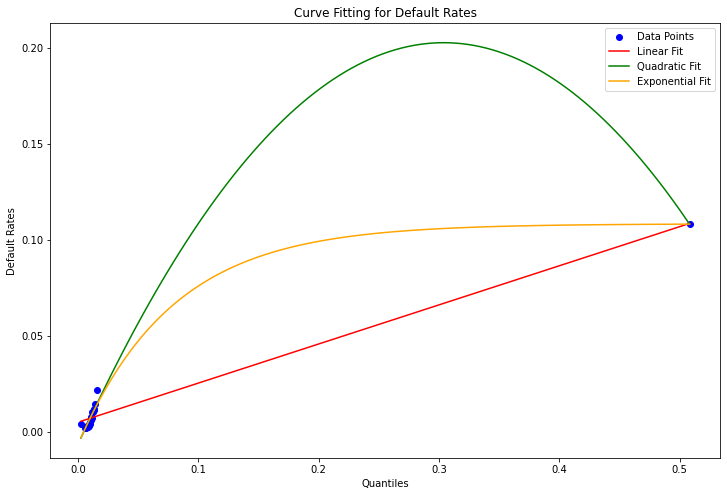

In [96]:
# Fit different curves
# Linear
def linear_func(x, a, b):
    return a * x + b

# Quadratic
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Exponential
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Fitting the curves
param_linear, _ = curve_fit(linear_func, quantiles, default_rates)
param_quadratic, _ = curve_fit(quadratic_func, quantiles, default_rates)
param_exponential, _ = curve_fit(exponential_func, quantiles, default_rates)

# Generate values for plotting
x_values = np.linspace(min(quantiles), max(quantiles), 100)
y_linear = linear_func(x_values, *param_linear)
y_quadratic = quadratic_func(x_values, *param_quadratic)
y_exponential = exponential_func(x_values, *param_exponential)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(quantiles, default_rates, label='Data Points', color='blue')
plt.plot(x_values, y_linear, label='Linear Fit', color='red')
plt.plot(x_values, y_quadratic, label='Quadratic Fit', color='green')
plt.plot(x_values, y_exponential, label='Exponential Fit', color='orange')
plt.xlabel('Quantiles')
plt.ylabel('Default Rates')
plt.title('Curve Fitting for Default Rates')
plt.legend()
plt.show()


In [23]:
from scipy.optimize import curve_fit

# Fit a nonlinear curve
def curve_func(x, a, b, c):
    return a * x**2 + b * x + c

def get_curve_params(df, model, k):
    ####################################################
    # Make sure this is used on the training set only! #
    ####################################################
    
    # Add model predictions to the dataframe
    df['prediction'] = model.predict(df)

    # Sort the dataframe based on model predictions
    df_sorted = df.sort_values(by='prediction', ascending=False)

    # Create k buckets
    N = len(df)
    bucket_size = N // k
    buckets = [df_sorted.iloc[i*bucket_size:(i+1)*bucket_size] for i in range(k)]

    # Calculate default rates
    default_rates = []
    quantiles = []
    for i, bucket in enumerate(buckets):
        default_rate = bucket['default_label'].mean()
        default_rates.append(default_rate)
        quantiles.append(bucket['prediction'].min())

    params, _ = curve_fit(curve_func, quantiles, default_rates)

    return params

def calibrate_prob(raw_prob, params):
    calibrate_prob = [curve_func(x, *params) for x in raw_prob]
    return calibrate_prob

In [123]:
# Check nan in the list
def check_nan_in_list(list):
    count = 0
    for i in list:
        if np.isnan(i):
            count += 1
    return count

check_nan_in_list(df_train['pred_proba'])

0

In [125]:
params = get_curve_params(df_train, model, 20)

df_test['pred_proba'] = model.predict(df_test)

# Calibrate the predictions
df_test['calibrated_pred_proba'] = calibrate_prob(df_test['pred_proba'], params)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(df_test['default_label'], df_test['calibrated_pred_proba'])

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.7985852755428411


## Find calibration coefficients on training data

In [21]:
df, param = impute_median_train(df_feat_eng_nan_impute)
my_formula = "default_label ~ " + " + ".join(final_columns)
features = final_columns + ['default_label']
logit_model_sm = estimator(df[features], my_formula)
calibration_coefficients = get_curve_params(df[features], logit_model_sm, 20)


Optimization terminated successfully.
         Current function value: 0.060798
         Iterations 11


In [28]:
calibration_coefficients

array([ 5.77341383e+02, -7.13208727e+00,  1.69458414e-02])